In [1]:
%load_ext autoreload
%autoreload 2

## Ising model
This notebook will explain the basics of the Ising model. In order to implement the different Ising Models we will use D-Wave's packages **[dimod](https://github.com/dwavesystems/dimod)** and **[neal](https://github.com/dwavesystems/dwave-neal)**, for defining the Ising model and solving it with simulated annealing, respectively.
#### Problem statement
We pose the Ising problem as the following optimization problem:
$$
\min_{\sigma \in \{ -1,+1 \}^n} H(\sigma) =\min_{\sigma \in \{ -1,+1 \}^n} \sum_{(ij) \in E(G)} J_{ij}\sigma_i\sigma_j + \sum_{i \in V(G)}h_i\sigma_i + c_I
$$
where we optimize over spins $\sigma \in \{ -1,+1 \}^n$, on a constrained graph $G(V,E)$, where the quadratic coefficients are $J_{ij}$ and the linear coefficients are $h_i$. We also include an arbitrary offset of the Ising model $c_I$.

In [2]:
# If using this on Google collab, we need to install the packages
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

# Let's start with Pyomo, dimod and neal
if IN_COLAB:
    !pip install -q pyomo
    !pip install dimod
    !pip install dwave-neal

In [3]:
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx
import os
import pickle
from scipy import stats
from matplotlib import ticker
import pyomo.environ as pyo


We are interested in solving a Sherrington-Kirkpatrick model where random \(\pm 1\) interactions in the Hamiltonian between fully connected graphs are given. We have 5 instances, each with 50 nodes.

In [4]:
# Load instances from Filip
instances_dir = 'instances'
instances_prefix = 'sk_model_N_50_inst_'
instance = 1
with open(f"{instances_dir}/{instances_prefix}{instance}.pkl", 'rb') as filein:
    hamiltonian_dictionary = pickle.load(filein)

FileNotFoundError: [Errno 2] No such file or directory: 'instances/sk_model_N_50_inst_1.pkl'

In [19]:
# Create own random instances
N = 300  # Number of variables
np.random.seed(42)  # Fixing the random seed to get the same result
J = np.random.choice([-1, 1], size=(N, N))
# J = np.random.rand(N, N)
# We only consider upper triangular matrix ignoring the diagonal
J = np.triu(J, 1)
h = np.zeros(N)

In [20]:
model_sk = dimod.BinaryQuadraticModel.from_ising(h, J, offset=0.0)


/tmp/ipykernel_11081/1323328964.py:1: DeprecationWarning: BinaryQuadraticModel.to_networkx_graph() is deprecated since dimod 0.10.0 and will be removed in 0.12.0. Use dimod.to_networkx_graph() instead.
  nx_graph = model_sk.to_networkx_graph()


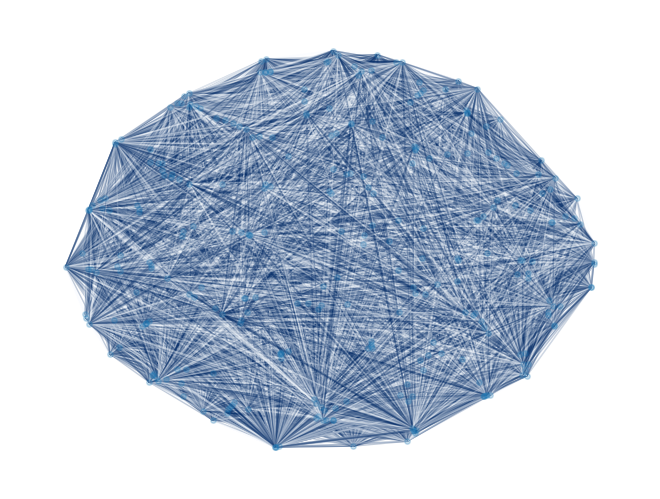

In [21]:
nx_graph = model_sk.to_networkx_graph()
edges, bias = zip(*nx.get_edge_attributes(nx_graph, 'bias').items())
bias = np.array(bias)
nx.draw(nx_graph, node_size=15, pos=nx.spring_layout(nx_graph),
        alpha=0.25, edgelist=edges, edge_color=bias, edge_cmap=plt.cm.Blues)


### Solution via Random Sampling

In [22]:
randomSampler = dimod.RandomSampler()
randomSample = randomSampler.sample(model_sk, num_reads=1000000)
energies = [datum.energy for datum in randomSample.data(
    ['energy'], sorted_by='energy')]
random_energy = np.mean(energies)
print('Average random energy = ' + str(random_energy))

Average random energy = -0.237202


In [23]:
# Some useful functions to get plots
def plot_energy_values(results, title=None):

    _, ax = plt.subplots()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by='energy')]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        ax.set(xlabel='bitstring for solution')
    else:
        samples = np.arange(len(energies))
        ax.set(xlabel='solution')

    ax.bar(samples, energies)
    ax.tick_params(axis='x', rotation=90)
    ax.set_ylabel('Energy')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax


def plot_samples(results, title=None, skip=1):
    _, ax = plt.subplots()
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        ax.set_xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        ax.set_xlabel('solution')

    counts = Counter(samples)
    total = len(samples)
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None, ax=ax)

    ax.tick_params(axis='x', rotation=80)
    ax.set_xticklabels([t.get_text()[:7] if not i %
                       skip else "" for i, t in enumerate(ax.get_xticklabels())])
    ax.set_ylabel('Probabilities')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax


def plot_energy_cfd(results, title=None, skip=1):
    _, ax = plt.subplots()
    # skip parameter given to avoid putting all xlabels
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None, ax=ax)
    ax.set_xticklabels([t.get_text()[:7] if not i %
                       skip else "" for i, t in enumerate(ax.get_xticklabels())])

    ax.set_xlabel('Energy')
    ax.set_ylabel('Probabilities')
    if title:
        ax.set_title(str(title))
    print("minimum energy:", min(energies))
    return ax


minimum energy: -996.0


<AxesSubplot: title={'center': 'Random sampling'}, xlabel='Energy', ylabel='Probabilities'>

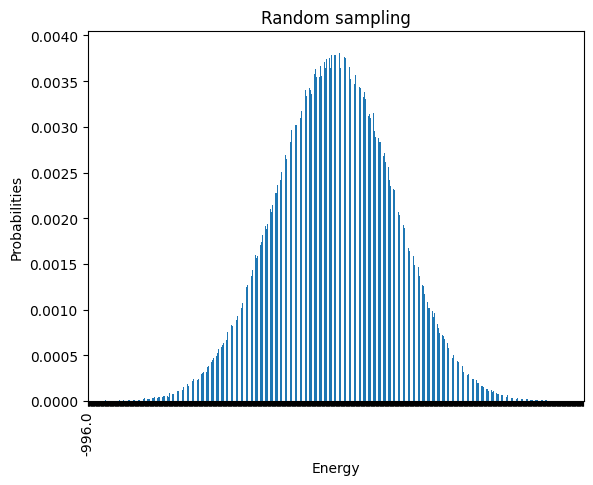

In [24]:
plot_energy_cfd(randomSample,
                   title='Random sampling',
                   skip=1000)


### Solution via simulated annealing
We will solve this problem using dwave-neal simulated annaling code initially in default parameters to assess performance.
The default number of simualted annealing sweeps is 1000.
The default limits of temperature given by the simulating annealing code are defined using the minimum and maximum nonzero coefficients in the Ising model. Then the range for beta is defined as $\beta \in \left[ \frac{\log(2)}{\max \{ \Delta E \} },\frac{\log(100)}{\min \{ \Delta E \} } \right]$, where $\Delta E = \min \{h_i \} + \sum_j J_{ij}+J_{ji}$.

Hot temperature: We want to scale hot_beta so that for the most unlikely qubit flip, we get at least 50% chance of flipping. (This means all other qubits will have > 50% chance of flipping initially). Most unlikely flip is when we go from a very low energy state to a high energy state, thus we calculate hot_beta based on max_delta_energy.
$$
0.50 = \exp(-\overline{\beta} * \max \{ \Delta E \})
$$

Cold temperature: Towards the end of the annealing schedule, we want to minimize the chance of flipping. Don't want to be stuck between small energy tweaks. Hence, set cold_beta so that at minimum energy change, the chance of flipping is set to 1%.
$$
0.01 = \exp(-\underline{\beta} * \min \{ \Delta E \})
$$

By default, the schedule also follows a geometric series.

In [25]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model_sk, num_reads=1000)

minimum energy: -3956.0
minimum energy: -3956.0


<AxesSubplot: title={'center': 'Simulated annealing in default parameters'}, xlabel='Energy', ylabel='Probabilities'>

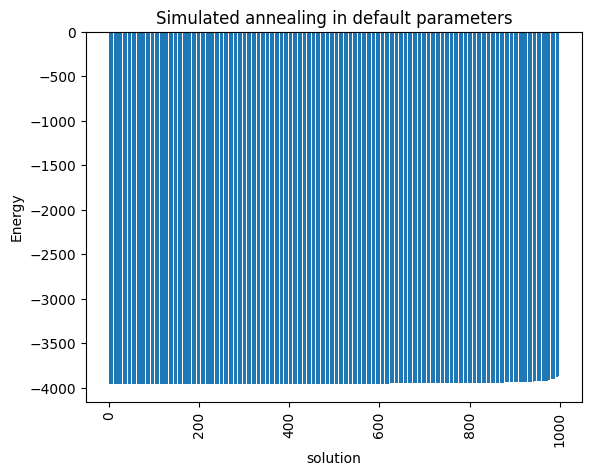

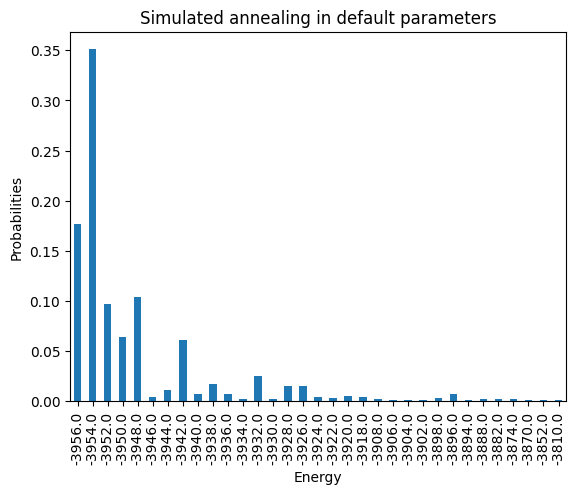

In [26]:
plot_energy_values(
    simAnnSamples, title='Simulated annealing in default parameters')
plot_energy_cfd(
    simAnnSamples, title='Simulated annealing in default parameters')

{'beta_range': [0.0011591089975918818, 5.154476330322146], 'beta_schedule_type': 'geometric'}


Text(0.5, 1.0, 'Default Geometric temperature schedule')

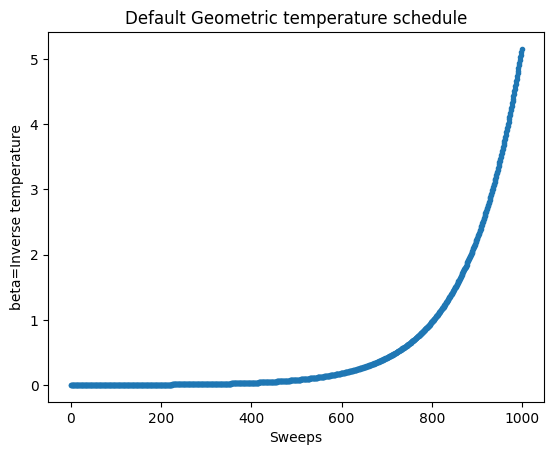

In [27]:
print(simAnnSamples.info)
beta_schedule = np.geomspace(*simAnnSamples.info['beta_range'], num=1000)
fig, ax = plt.subplots()
ax.plot(beta_schedule, '.')
ax.set_xlabel('Sweeps')
ax.set_ylabel('beta=Inverse temperature')
ax.set_title('Default Geometric temperature schedule')

In [29]:
s = 0.99
# sweeps = list(chain(np.arange(1,10,1),np.arange(10,30,2), np.arange(30,50,5), np.arange(50,100,10) ,np.arange(100,1001,100)))
sweeps = list(chain(
    np.arange(1, 5, 1),  
    np.arange(5, 150, 5),
    np.arange(150, 500, 25), 
    np.arange(500, 1000, 100)))
schedules = ['geometric', 'linear']
opt_energy = -3956
results_single = {}
results_single['p'] = {}
results_single['tts'] = {}
results_single['t'] = {}
for schedule in schedules:
    probs = []
    time_to_sol = []
    times = []
    for sweep in sweeps:
        start = time.time()
        samples = simAnnSampler.sample(
            model_sk, num_reads=1000, num_sweeps=sweep, beta_schedule_type=schedule)
        time_s = time.time() - start
        energies = samples.data_vectors['energy']
        occurrences = samples.data_vectors['num_occurrences']
        total_counts = sum(occurrences)
        counts = {}
        for index, energy in enumerate(energies):
            if energy in counts.keys():
                counts[energy] += occurrences[index]
            else:
                counts[energy] = occurrences[index]
        pr = sum(counts[key]
                 for key in counts.keys() if key <= opt_energy)/total_counts
        probs.append(pr)
        if pr == 0:
            time_to_sol.append(np.inf)
        else:
            time_to_sol.append(time_s*math.log10(1-s)/math.log10(1-pr))
        times.append(time_s)
    results_single['p'][schedule] = probs
    results_single['tts'][schedule] = time_to_sol
    results_single['t'][schedule] = times


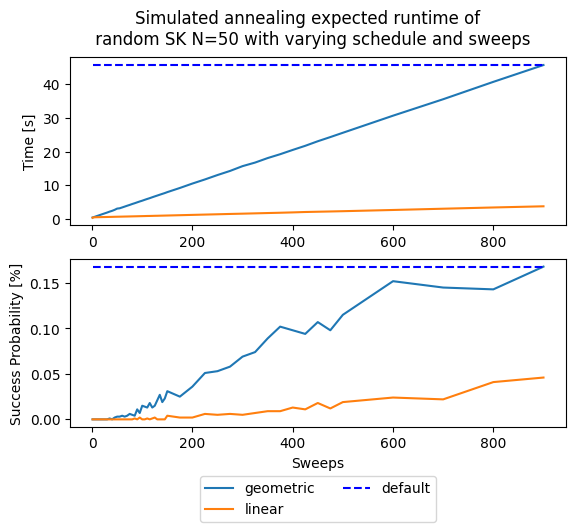

In [30]:
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Simulated annealing expected runtime of \n' +
             ' random SK N=50 with varying schedule and sweeps')

for schedule in schedules:
    ax1.plot(sweeps, results_single['t'][schedule], '-', label=schedule)
ax1.hlines(results_single['t']['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')

ax1.set(ylabel='Time [s]')

for schedule in schedules:
    ax2.plot(sweeps, results_single['p'][schedule], '-', label=schedule)
ax2.hlines(results_single['p']['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')

ax2.set(ylabel='Success Probability [%]')
ax2.set(xlabel='Sweeps')

plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.25))

These plots represent ofter contradictory metrics, on one hand you would like to obtain a large probability of finding a right solution (the definition of right comes from what you define as success). On the other hand, the time it takes to solve these cases should be as small as possible.
This is why we are interested in a metric that combines both, and that is why we settle on the Time To Solution (TTS) which is defined as
$$
TTS = \frac{\log{1-s}}{\log{1-p}}
$$
where s is a success factor, usually takes as $s = 99\%$, and $p$ is the success probability, usually accounted as the observed success probability.

One usually reads this as the time to solution within 99\% probability.

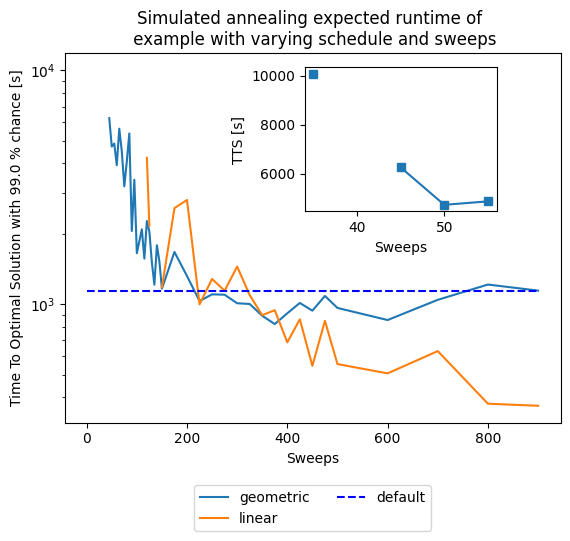

In [31]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
for schedule in schedules:
    ax1.semilogy(sweeps, results_single['tts'][schedule], '-', label=schedule)


# Value for the default solution
ttsDefault = results_single['tts']['geometric'][-1]
ax1.hlines(ttsDefault, sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')


ax1.set_ylabel('Time To Optimal Solution with ' + str(s*100) + ' % chance [s]')
ax1.set_xlabel('Sweeps')
ax1.set_title('Simulated annealing expected runtime of \n' +
              ' example with varying schedule and sweeps')

ax2 = plt.axes([.5, .55, .3, .3])
for schedule in schedules:
    ax2.plot(sweeps[5:15], results_single['tts'][schedule][5:15], '-s')
ax2.set_ylabel('TTS [s]')
ax2.set_xlabel('Sweeps')


ax1.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.15))


In [32]:
current_path = os.getcwd()
pickle_path = os.path.join(current_path, 'results_300/')
if not(os.path.exists(pickle_path)):
    print('Results directory ' + pickle_path +
          ' does not exist. We will create it.')
    os.makedirs(pickle_path)


In [33]:
import zipfile
zip_name = os.path.join(pickle_path, 'results.zip')
overwrite_pickles = False
use_raw_data = True
if os.path.exists(zip_name) and use_raw_data:
    with zipfile.ZipFile(zip_name, 'r') as zip_ref:
        zip_ref.extractall(pickle_path)
    print('Results zip file has been extrated to ' + pickle_path)


In [45]:
s = 0.99  # This is the success probability for the TTS calculation
treshold = 1.0  # This is a percentual treshold of what the minimum energy should be
sweeps = list(chain(
    np.arange(1, 5, 1),
    np.arange(5, 150, 5),
    np.arange(150, 1000, 25)
    ))
schedules = ['geometric', 'linear']
# schedules = ['geometric']
total_reads = 1000
default_sweeps = 1000
n_boot = 500
ci = 68  # Confidence interval for bootstrapping
default_boots = default_sweeps
boots = [1, 10, default_boots]
min_energy = -3956
instance = 42
results_name = "results_" + str(instance) + ".pkl"
results_name = os.path.join(pickle_path, results_name)
results = {}
results['p'] = {}
results['min_energy'] = {}
results['random_energy'] = {}
results['tts'] = {}
results['ttsci'] = {}
results['t'] = {}
results['best'] = {}
results['bestci'] = {}
# If you wanto to use the raw data and process it here
if use_raw_data or not(os.path.exists(results_name)):
    # If you want to generate the data or load it here
    overwrite_pickles = False

    for boot in boots:
        results['p'][boot] = {}
        results['tts'][boot] = {}
        results['ttsci'][boot] = {}
        results['best'][boot] = {}
        results['bestci'][boot] = {}

    for schedule in schedules:
        probs = {k: [] for k in boots}
        time_to_sol = {k: [] for k in boots}
        prob_np = {k: [] for k in boots}
        ttscs = {k: [] for k in boots}
        times = []
        b = {k: [] for k in boots}
        bnp = {k: [] for k in boots}
        bcs = {k: [] for k in boots}
        for sweep in sweeps:
            # Gather instance names
            pickle_name = str(instance) + "_" + schedule + \
                "_" + str(sweep) + ".p"
            pickle_name = os.path.join(pickle_path, pickle_name)
            # If the instance data exists, load the data
            if os.path.exists(pickle_name) and not overwrite_pickles:
                # print(pickle_name)
                samples = pickle.load(open(pickle_name, "rb"))
                time_s = samples.info['timing']
            # If it does not exist, generate the data
            else:
                start = time.time()
                samples = simAnnSampler.sample(
                    model_sk, num_reads=total_reads, num_sweeps=sweep, beta_schedule_type=schedule)
                time_s = time.time() - start
                samples.info['timing'] = time_s
                pickle.dump(samples, open(pickle_name, "wb"))
            # Compute statistics
            energies = samples.data_vectors['energy']
            occurrences = samples.data_vectors['num_occurrences']
            total_counts = sum(occurrences)
            times.append(time_s)
            if min(energies) < min_energy:
                min_energy = min(energies)
                print("A better solution of " + str(min_energy) +
                      " was found for sweep " + str(sweep))
            # success = min_energy*(1.0 + treshold/100.0)**np.sign(min_energy)
            success = random_energy - \
                (random_energy - min_energy)*(1.0 - treshold/100.0)

            # Best of boot samples es computed via n_boot bootstrappings
            boot_dist = {}
            pr_dist = {}
            cilo = {}
            ciup = {}
            pr = {}
            pr_cilo = {}
            pr_ciup = {}
            for boot in boots:
                boot_dist[boot] = []
                pr_dist[boot] = []
                for i in range(int(n_boot)):
                    resampler = np.random.randint(0, total_reads, boot)
                    sample_boot = energies.take(resampler, axis=0)
                    # Compute the best along that axis
                    boot_dist[boot].append(min(sample_boot))

                    occurences = occurrences.take(resampler, axis=0)
                    counts = {}
                    for index, energy in enumerate(sample_boot):
                        if energy in counts.keys():
                            counts[energy] += occurences[index]
                        else:
                            counts[energy] = occurences[index]
                    pr_dist[boot].append(
                        sum(counts[key] for key in counts.keys() if key < success)/boot)

                b[boot].append(np.mean(boot_dist[boot]))
                # Confidence intervals from bootstrapping the best out of boot
                bnp[boot] = np.array(boot_dist[boot])
                cilo[boot] = np.apply_along_axis(
                    stats.scoreatpercentile, 0, bnp[boot], 50.-ci/2.)
                ciup[boot] = np.apply_along_axis(
                    stats.scoreatpercentile, 0, bnp[boot], 50.+ci/2.)
                bcs[boot].append((cilo[boot], ciup[boot]))
                # Confidence intervals from bootstrapping the TTS of boot
                prob_np[boot] = np.array(pr_dist[boot])
                pr[boot] = np.mean(prob_np[boot])
                probs[boot].append(pr[boot])
                if prob_np[boot].all() == 0:
                    time_to_sol[boot].append(np.inf)
                    ttscs[boot].append((np.inf, np.inf))
                else:
                    pr_cilo[boot] = np.apply_along_axis(
                        stats.scoreatpercentile, 0, prob_np[boot], 50.-ci/2.)
                    pr_ciup[boot] = np.apply_along_axis(
                        stats.scoreatpercentile, 0, prob_np[boot], 50.+ci/2.)
                    time_to_sol[boot].append(
                        time_s*math.log10(1-s)/math.log10(1-pr[boot]+1e-9))
                    ttscs[boot].append((time_s*math.log10(1-s)/math.log10(
                        1-pr_cilo[boot]+1e-9), time_s*math.log10(1-s)/math.log10(1-pr_ciup[boot]+1e-9)))

        results['t'][schedule] = times
        results['min_energy'][schedule] = min_energy
        results['random_energy'][schedule] = random_energy
        for boot in boots:
            results['p'][boot][schedule] = probs[boot]
            results['tts'][boot][schedule] = time_to_sol[boot]
            results['ttsci'][boot][schedule] = ttscs[boot]
            results['best'][boot][schedule] = [
                (random_energy - energy) / (random_energy - min_energy) for energy in b[boot]]
            results['bestci'][boot][schedule] = [tuple((random_energy - element) / (
                random_energy - min_energy) for element in energy) for energy in bcs[boot]]

    # Save results file in case that we are interested in reusing them
    pickle.dump(results, open(results_name, "wb"))
else:  # Just reload processed datafile
    results = pickle.load(open(results_name, "rb"))


[(0.8, 1.01)]

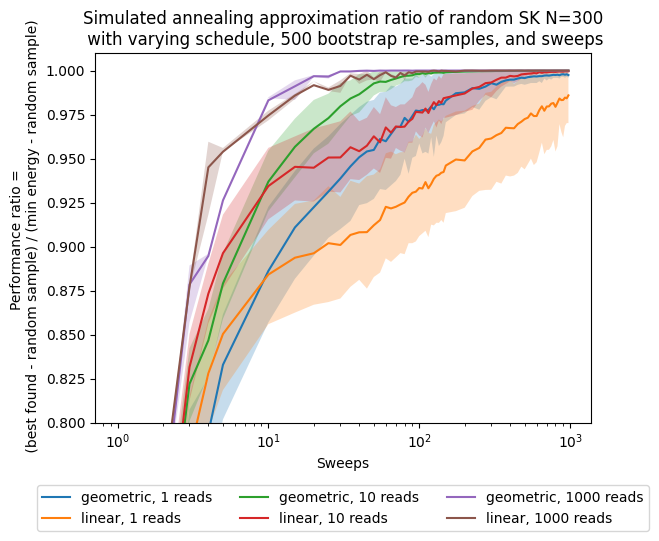

In [53]:
fig, ax = plt.subplots()
boots = [1, 10, default_boots]
for boot in boots:
    for schedule in schedules:
        ax.plot(sweeps, results['best'][boot][schedule], label=str(
            schedule) + ', ' + str(boot) + ' reads')
        bestnp = np.stack(results['bestci'][boot][schedule], axis=0).T
        ax.fill_between(sweeps, bestnp[0], bestnp[1], alpha=0.25)
ax.set(xlabel='Sweeps')
ax.set(ylabel='Performance ratio = \n ' +
       '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing approximation ratio of random SK N=300\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8, 1.01])
# ax.set(xlim=[1,200])


[(0.8, 1.01)]

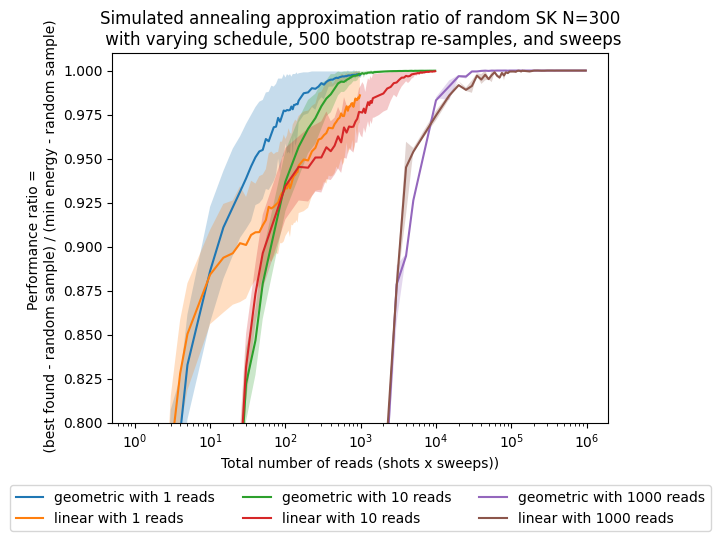

In [54]:
fig, ax = plt.subplots()
boots = [1, 10, default_boots]
for boot in boots:
    reads = [s * boot for s in sweeps]
    for schedule in schedules:
        ax.plot(reads, results['best'][boot][schedule], label=str(
            schedule) + ' with ' + str(boot) + ' reads')
        bestnp = np.stack(results['bestci'][boot][schedule], axis=0).T
        ax.fill_between(reads, bestnp[0], bestnp[1], alpha=0.25)
ax.set(xlabel='Total number of reads (shots x sweeps))')
ax.set(ylabel='Performance ratio = \n ' +
       '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing approximation ratio of random SK N=300\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.15))
ax.set(xscale='log')
ax.set(ylim=[0.8, 1.01])
# ax.set(xlim=[1,200])


minimum TTS for geometric schedule = 46.70686690546172s at sweep = 225
minimum TTS for linear schedule = 21.897824627543432s at sweep = 925


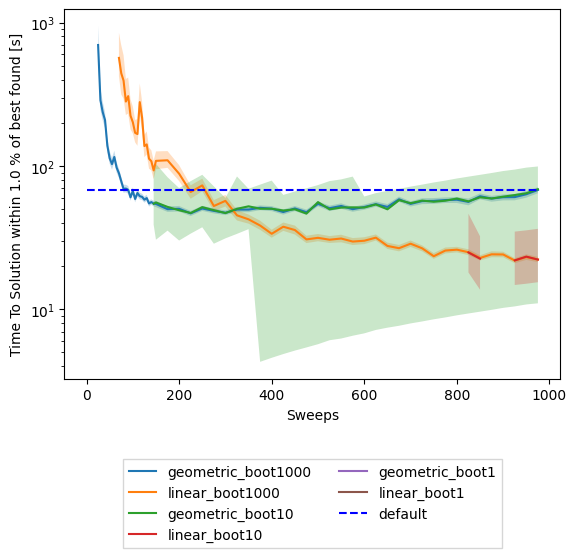

In [55]:
fig1, ax1 = plt.subplots()
boots = [1, 10, default_boots]

for boot in reversed(boots):
    for schedule in schedules:
        ax1.plot(sweeps, results['tts'][boot][schedule],
                 label=schedule + "_boot" + str(boot))
        ttsnp = np.stack(results['ttsci'][boot][schedule], axis=0).T
        ax1.fill_between(sweeps, ttsnp[0], ttsnp[1], alpha=0.25)


ax1.hlines(results['tts'][total_reads]['geometric'][-1], sweeps[0], sweeps[-1],
           linestyle='--', label='default', colors='b')

ax1.set(yscale='log')
# ax1.set(ylim=[3, 1e3])
# ax1.set(xlim=[1,200])

ax1.set(ylabel='Time To Solution within ' +
        str(treshold) + ' % of best found [s]')
ax1.set(xlabel='Sweeps')
ax.set_title('Simulated annealing expected runtime of random SK N=300\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
           ncol=2, fancybox=False, shadow=False)

# ax2 = plt.axes([.45, .25, .4, .3])
min_tts = dict.fromkeys(schedules)
min_index = dict.fromkeys(schedules)
min_sweep = dict.fromkeys(schedules)
delta_index = 0
for schedule in schedules:
    min_tts[schedule] = min(results['tts'][default_sweeps][schedule])
    min_index[schedule] = results['tts'][default_sweeps][schedule].index(min_tts[schedule])
    min_sweep[schedule] = sweeps[results['tts'][default_sweeps][schedule].index(min_tts[schedule])]
    print("minimum TTS for " + schedule + " schedule = " +
          str(min_tts[schedule]) + "s at sweep = " + str(min_sweep[schedule]))
#     ax2.semilogy(sweeps[min_index[schedule]-delta_index:min_index[schedule]+delta_index], results['tts']
#                   [default_sweeps][schedule][min_index[schedule]-delta_index:min_index[schedule]+delta_index], '-s')
#     ax2.hlines(results['tts'][default_sweeps]['geometric'][-1], sweeps[min_index[schedule]-delta_index], sweeps[min_index[schedule]+delta_index],
#            linestyle='--', label='default', colors='b')

# ax2.set(ylabel='TTS [s]')
# ax2.set(xlabel='Sweeps')

NameError: name 'interest_sweeps' is not defined

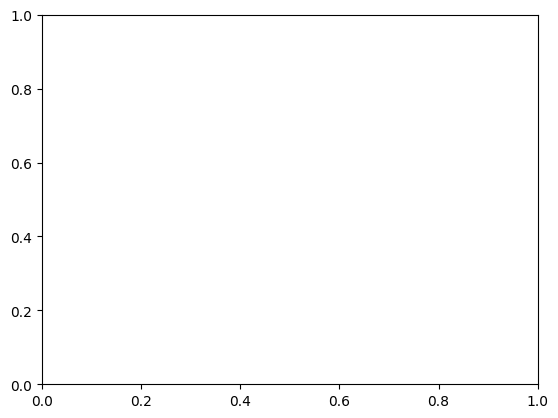

In [52]:
fig, ax = plt.subplots()

# Gather instance names
instance = 42
for sweep in interest_sweeps:
    for schedule in schedules:
        if sweep in approx_ratio[schedule].keys() and sweep in approx_ratioci[schedule].keys():
            pass
        else:
            min_energy = results['min_energy'][schedule]
            random_energy = results['random_energy'][schedule]

            pickle_name = str(instance) + "_" + schedule + \
                "_" + str(sweep) + ".p"
            pickle_name = os.path.join(pickle_path, pickle_name)
            # If the instance data exists, load the data
            if os.path.exists(pickle_name) and not overwrite_pickles:
                # print(pickle_name)
                samples = pickle.load(open(pickle_name, "rb"))
                time_s = samples.info['timing']
            # If it does not exist, generate the data
            else:
                start = time.time()
                samples = simAnnSampler.sample(
                    model_sk, num_reads=total_reads, num_sweeps=sweep, beta_schedule_type=schedule)
                time_s = time.time() - start
                samples.info['timing'] = time_s
                pickle.dump(samples, open(pickle_name, "wb"))
            # Compute statistics
            energies = samples.data_vectors['energy']
            if min(energies) < min_energy:
                min_energy = min(energies)
                print("A better solution of " + str(min_energy) +
                      " was found for sweep " + str(sweep))

            b = []
            bcs = []
            probs = []
            time_to_sol = []
            for boot in boots:
                boot_dist = []
                pr_dist = []
                for i in range(int(n_boot - boot + 1)):
                    resampler = np.random.randint(0, total_reads, boot)
                    sample_boot = energies.take(resampler, axis=0)
                    # Compute the best along that axis
                    boot_dist.append(min(sample_boot))

                b.append(np.mean(boot_dist))
                # Confidence intervals from bootstrapping the best out of boot
                bnp = np.array(boot_dist)
                cilo = np.apply_along_axis(
                    stats.scoreatpercentile, 0, bnp, 50.-ci/2.)
                ciup = np.apply_along_axis(
                    stats.scoreatpercentile, 0, bnp, 50.+ci/2.)
                bcs.append((cilo, ciup))

            approx_ratio[schedule][sweep] = [
                (random_energy - energy) / (random_energy - min_energy) for energy in b]
            approx_ratioci[schedule][sweep] = [tuple((random_energy - element) / (
                random_energy - min_energy) for element in energy) for energy in bcs]

        ax.plot([shot*sweep for shot in boots], approx_ratio[schedule]
                [sweep], label=schedule + ',' + str(sweep) + ' sweeps')
        approx_ratio_bestci_np = np.stack(
            approx_ratioci[schedule][sweep], axis=0).T
        ax.fill_between([shot*sweep for shot in boots],
                        approx_ratio_bestci_np[0], approx_ratio_bestci_np[1], alpha=0.25)
ax.set(xscale='log')
ax.set(ylim=[0.9, 1.01])
# ax.set(xlim=[1e2, 1e4])
ax.set(xlabel='Total number of reads (equivalent to time)')
ax.set(ylabel='Approximation ratio = \n ' +
       '(best found - random sample) / (min energy - random sample)')
ax.set_title('Simulated annealing approximation ratio of SK ' + str(instance) + ' N=50\n' +
             ' with varying schedule, ' + str(n_boot) + ' bootstrap re-samples, and sweeps')
plt.legend()


In [96]:
sweep

[1000, 10, 500]

### Solution via MIP
We consider solving the problem through Mixed-Integer Programming by a reformulation of the form

$$
\min_{\mathbf{x}} \mathbf{x}^\top Q \mathbf{x}\\
s.t. \mathbf{x} \in \{0,1 \}^{n}
$$
being the same as 

$$
\min_{\mathbf{x},\mathbf{y}} Q \odot \mathbf{y}\\
s.t. y_{ij} \geq x_i + x_j - 1 \\
y_{ij} \leq x_i \\
y_{ij} \leq x_j \\
\mathbf{x} \in \{0,1 \}^{n} \\
\mathbf{y} \in \{0,1 \}^{n \times n}
$$

where $\odot$ is the element-wise multiplication

In [20]:
# We do not need to worry about the transformation to QUBO since dimod takes care of it
Q, c = model_sk.to_qubo()

# Define the model
model_pyo = pyo.ConcreteModel(name='Random SK model N=50 modeled as linaerized MIP')

I = range(len(model_sk))
J = range(len(model_sk))
#Define the original variables
model_pyo.x = pyo.Var(I, domain=pyo.Binary)
# Define the edges variables
model_pyo.y = pyo.Var(I, J, domain=pyo.Binary)

obj_expr = c

# add model constraints
model_pyo.c1 = pyo.ConstraintList()
model_pyo.c2 = pyo.ConstraintList()
model_pyo.c3 = pyo.ConstraintList()
for (i,j) in Q.keys():
    if i != j:
        model_pyo.c1.add(model_pyo.y[i,j] >= model_pyo.x[i] + model_pyo.x[j] - 1)
        model_pyo.c2.add(model_pyo.y[i,j] <= model_pyo.x[i])
        model_pyo.c3.add(model_pyo.y[i,j] <= model_pyo.x[j])
        obj_expr += Q[i,j]*model_pyo.y[i,j]
    else:
        obj_expr += Q[i,j]*model_pyo.x[i]

# Define the objective function
model_pyo.objective = pyo.Objective(expr = obj_expr, sense=pyo.minimize)
# Print the model
model_pyo.display()

Model Random SK model N=50 modeled as linaerized MIP

  Variables:
    x : Size=50, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary
         10 :     0 :  None :     1 : False :  True : Binary
         11 :     0 :  None :     1 : False :  True : Binary
         12 :     0 :  None :     1 : False :  True : Binary
         13 :     0 :  None :     1 : False :  T

In [21]:
opt_gurobi = pyo.SolverFactory('gurobi')

In [25]:
result_obj = opt_gurobi.solve(model_pyo, tee=False, timelimit=10)

Exception in thread Thread-11:
Traceback (most recent call last):
  File "/home/bernalde/anaconda3/envs/stochastic-benchmark/lib/python3.9/threading.py", line 980, in _bootstrap_inner
    self.run()
  File "/home/bernalde/anaconda3/envs/stochastic-benchmark/lib/python3.9/threading.py", line 917, in run
    self._target(*self._args, **self._kwargs)
  File "/home/bernalde/anaconda3/envs/stochastic-benchmark/lib/python3.9/site-packages/pyomo/common/tee.py", line 513, in _mergedReader
    new_data = os.read(handle.read_pipe, io.DEFAULT_BUFFER_SIZE)
OSError: [Errno 9] Bad file descriptor


TimeoutExpired: Command '['/opt/gurobi950/linux64/bin/gurobi.sh']' timed out after 10.999096212908626 seconds

In [24]:
model_pyo.display()

Model Random SK model N=50 modeled as linaerized MIP

  Variables:
    x : Size=50, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary
         10 :     0 :  None :     1 : False :  True : Binary
         11 :     0 :  None :     1 : False :  True : Binary
         12 :     0 :  None :     1 : False :  True : Binary
         13 :     0 :  None :     1 : False :  T